In [1]:
%load_ext autoreload
%autoreload 0

In [2]:
%autoreload

In [3]:
import sys
sys.path.append('/pollard/home/bsmith/Projects/haplo-benchmark/include/StrainFacts')

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from lib.pandas_util import idxwhere
import sfacts as sf
import numpy as np
import xarray as xr
import seaborn as sns
from scipy.spatial.distance import cdist
import lib.plot
from tqdm import tqdm
from itertools import product
import lib.stats

def pvalue_to_significance_marker(p):
    if p < 1e-3:
        return '**'
    if p < 0.05:
        return '*'
    if p >= 0.05:
        return ''

In [5]:
#"data/sfacts_simulate-model_simplest_simulation-n{n}-g250-s{sim_s}-pi40-mu100-eps10-seed{sim_seed}.metagenotype-n{n}-g250.fit-sfacts41_gpu-s{fit_s}-seed{fit_seed}.evaluation.tsv"
n_to_s_ratio = 5

_benchmarks = []
for g, s, fit_type, sim_seed, fit_seed, fit_s_ratio in tqdm(list(product(
    [250, 1000],
    [10, 20, 40, 80, 200, 500],
    ['sfinder', 'sfacts44_gpu', 'sfacts44_cpu'],
    range(5),
    range(5),
    [1, 1.5],
))):
    n = int(s * n_to_s_ratio)
    sim_prefix = f"data/sfacts_simulate-model_simplest_simulation-n{n}-g{g}-s{s}-pi40-mu100-eps10-seed{sim_seed}"
    mgen_prefix = f"{sim_prefix}.metagenotype-n{n}-g{g}"
    fit_s = int(s * fit_s_ratio)
    eval_path = f"{mgen_prefix}.fit-{fit_type}-s{fit_s}-seed{fit_seed}.evaluation.tsv"
    try:
        bench = pd.read_table(eval_path, index_col='fit_path')
    except FileNotFoundError:
#         print(f"{eval_path} not found")
        continue
    
    meta_dict = dict(
        sim_seed=sim_seed,
        fit_seed=fit_seed,
        n=n,
        g=g,
        s=s,
        fit_s_ratio=fit_s_ratio,
        fit_s=fit_s,
        fit_type=fit_type,
    )
    for key in meta_dict:
        bench[key] = meta_dict[key]
    _benchmarks.append(bench)
_benchmarks = pd.concat(_benchmarks)
print(_benchmarks.shape)
benchmarks2 = _benchmarks

100%|██████████| 1800/1800 [00:10<00:00, 169.61it/s]


(650, 19)


In [6]:
eval_path

'data/sfacts_simulate-model_simplest_simulation-n2500-g1000-s500-pi40-mu100-eps10-seed4.metagenotype-n2500-g1000.fit-sfacts44_cpu-s750-seed4.evaluation.tsv'

In [7]:
#"data/sfacts_simulate-model_simplest_simulation-n{n}-g250-s{sim_s}-pi40-mu100-eps10-seed{sim_seed}.metagenotype-n{n}-g250.fit-sfacts41_gpu-s{fit_s}-seed{fit_seed}.evaluation.tsv"
n_to_s_ratio = 5

_benchmarks = []
for g, s, fit_type, sim_seed, fit_seed, fit_s_ratio in tqdm(list(product(
    [250, 1000],
    [10, 20, 40, 80, 200, 500],
    ['sfinder', 'sfacts44_gpu', 'sfacts44_cpu'],
    range(5),
    range(5),
    [1, 1.5],
))):
    n = int(s * n_to_s_ratio)
    sim_prefix = f"data/sfacts_simulate-model_simplest_simulation-n{n}-g{g}-s{s}-pi40-mu100-eps10-seed{sim_seed}"
    mgen_prefix = f"{sim_prefix}.metagenotype-n{n}-g{g}"
    fit_s = int(s * fit_s_ratio)
    eval_path = f"{mgen_prefix}.fit-{fit_type}-s{fit_s}-seed{fit_seed}.benchmark"
    try:
        bench = pd.read_table(eval_path)
    except FileNotFoundError:
#         print(f"{eval_path} not found")
        continue
    
    bench = bench['s'].to_frame(name='runtime_s')
    
    meta_dict = dict(
        sim_seed=sim_seed,
        fit_seed=fit_seed,
        n=n,
        g=g,
        s=s,
        fit_s_ratio=fit_s_ratio,
        fit_s=fit_s,
        fit_type=fit_type,
    )
    for key in meta_dict:
        bench[key] = meta_dict[key]
    _benchmarks.append(bench)
_benchmarks = pd.concat(_benchmarks)
print(_benchmarks.shape)
benchmarks1 = _benchmarks

100%|██████████| 1800/1800 [00:14<00:00, 123.09it/s]


(751, 9)


In [8]:
(
    benchmarks1
    .groupby([
        'n',
        'fit_type',
#         'sim_seed',
        'fit_s_ratio',
    ])
    .apply(len)
    .unstack('fit_type')
)

fit_type          sfacts44_cpu  sfacts44_gpu  sfinder
n    fit_s_ratio                                     
50   1.0                  25.0          25.0     25.0
     1.5                  25.0          25.0     25.0
100  1.0                  25.0          25.0     25.0
     1.5                  25.0          25.0     25.0
200  1.0                  25.0          25.0     25.0
     1.5                  25.0          25.0     25.0
400  1.0                  25.0          25.0     25.0
     1.5                  25.0          25.0     25.0
1000 1.0                  25.0          25.0      1.0
     1.5                  25.0          25.0      NaN
2500 1.0                   NaN          25.0      NaN
     1.5                   NaN          25.0      NaN

Text(0.5, 0, 'samples (N)')

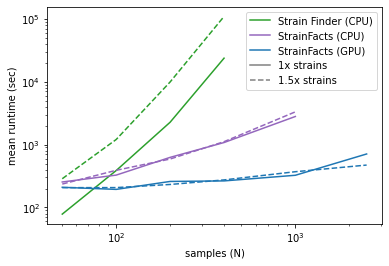

In [103]:
# Aggregate simulation results by finding the mean/min/std of each fit_seed
# and then taking the mean of each of these values over the sim_seed.
# I could then plot each runtime value as the mean


palette = {
# 'sfinder', 'sfacts1_cpu', 'sfacts1_gpu', 'sfacts2', 'sfacts3'
    'sfacts44_cpu': 'tab:purple',
    'sfacts44_gpu': 'tab:blue',
#     'sfacts41_big': 'lightblue',
    'sfinder': 'tab:green',
}

d0 = (
    benchmarks1
    .groupby([
        'n',
        'fit_type',
        'sim_seed',
        'fit_s_ratio',
    ])
    .runtime_s
    .agg(['mean', 'max', 'min', 'std', 'count'])
    .reset_index()
    .groupby([
        'n',
        'fit_type',
        'fit_s_ratio',
    ])
    .agg(['mean', 'max', 'median', 'count'])
    .reset_index()
)
# Drop the one sfinder run:
d0 = d0.drop(d0[lambda x: (x.n == 1_000) & (x.fit_s_ratio == 1) & (x.fit_type == 'sfinder')].index)

fig = plt.figure()

fit_label_map = {
    'sfacts44_gpu': 'StrainFacts (GPU)',
    'sfacts44_cpu': 'StrainFacts (CPU)',
    'sfinder': 'Strain Finder (CPU)'

}

for fit_type in ['sfinder', 'sfacts44_cpu', 'sfacts44_gpu']:
    d1 = d0[lambda x: x.fit_s_ratio==1].sort_values('n')[lambda x: x.fit_type == fit_type]
    if not fit_type in palette:
        continue
    plt.plot(d1['n'], d1[('mean', 'mean')], c=palette[fit_type], label=fit_label_map[fit_type])
    
    
for fit_type, d1 in d0[lambda x: x.fit_s_ratio==1.5].sort_values('n').groupby('fit_type'):
    if not fit_type in palette:
        continue
    plt.plot(d1['n'], d1[('mean', 'mean')], c=palette[fit_type], linestyle='--', label='__nolegend__')
    
plt.plot([], [], c='grey', linestyle='-', label='1x strains')
plt.plot([], [], c='grey', linestyle='--', label='1.5x strains')

plt.yscale('log')
plt.xscale('log')
plt.legend()

plt.ylabel('mean runtime (sec)')
plt.xlabel('samples (N)')

In [10]:
d0[lambda x: x.fit_type=='sfacts44_cpu'].set_index(['n', 'fit_s_ratio'])[[('max', 'max'), ('mean', 'mean')]] / 3600

max      mean
                       max      mean
n    fit_s_ratio                    
50   1.0          0.209832  0.070701
     1.5          0.100587  0.065565
100  1.0          0.229811  0.090964
     1.5          0.251100  0.108436
200  1.0          0.406605  0.174178
     1.5          0.233804  0.163974
400  1.0          0.605710  0.299873
     1.5          0.675043  0.309470
1000 1.0          1.618439  0.778236
     1.5          2.236372  0.922370

In [11]:
d0[lambda x: x.fit_type=='sfacts44_gpu'].set_index(['n', 'fit_s_ratio'])[[('max', 'max'), ('mean', 'mean')]] / 3600

max      mean
                       max      mean
n    fit_s_ratio                    
50   1.0          0.088754  0.058191
     1.5          0.099021  0.057452
100  1.0          0.090615  0.053913
     1.5          0.089584  0.057573
200  1.0          0.116331  0.072116
     1.5          0.114941  0.064560
400  1.0          0.122156  0.073563
     1.5          0.110214  0.076277
1000 1.0          0.138209  0.090398
     1.5          0.161282  0.102982
2500 1.0          0.259071  0.197238
     1.5          0.183621  0.131381

In [12]:
d0[lambda x: x.fit_type=='sfinder'].set_index(['n', 'fit_s_ratio'])[[('max', 'max'), ('mean', 'mean')]] / 3600

max       mean
                       max       mean
n   fit_s_ratio                      
50  1.0           0.041466   0.021796
    1.5           0.177754   0.079682
100 1.0           0.219699   0.107576
    1.5           0.601040   0.335148
200 1.0           1.002802   0.630786
    1.5           4.730648   2.755735
400 1.0          10.764358   6.588732
    1.5          51.704260  30.367859

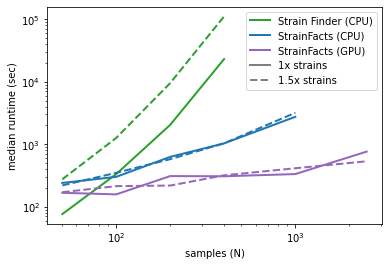

In [180]:
# Aggregate simulation results by finding the mean/min/std of each fit_seed
# and then taking the mean of each of these values over the sim_seed.
# I could then plot each runtime value as the mean

fit_type_list = ['sfinder', 'sfacts44_cpu', 'sfacts44_gpu']

palette = {
# 'sfinder', 'sfacts1_cpu', 'sfacts1_gpu', 'sfacts2', 'sfacts3'
    'sfacts44_cpu': 'tab:blue',
    'sfacts44_gpu': 'tab:purple',
#     'sfacts41_big': 'lightblue',
    'sfinder': 'tab:green',
}

d0 = (
    benchmarks1
    .groupby([
        'n',
        'fit_type',
#         'sim_seed',
        'fit_s_ratio',
    ])
    .runtime_s
    .agg(['median'])
    .reset_index()
)
# Drop the one sfinder run:
d0 = d0.drop(d0[lambda x: (x.n == 1_000) & (x.fit_s_ratio == 1) & (x.fit_type == 'sfinder')].index)

fig = plt.figure()

fit_label_map = {
    'sfacts44_gpu': 'StrainFacts (GPU)',
    'sfacts44_cpu': 'StrainFacts (CPU)',
    'sfinder': 'Strain Finder (CPU)'

}

for fit_type in fit_type_list:
    d1 = d0[lambda x: x.fit_s_ratio==1].sort_values('n')[lambda x: x.fit_type == fit_type]
    if not fit_type in palette:
        continue
    plt.plot(d1['n'], d1['median'], c=palette[fit_type], linestyle='-', label=fit_label_map[fit_type], lw=2)
    
    
for fit_type in fit_type_list:
    d1 = d0[lambda x: x.fit_s_ratio==1.5].sort_values('n')[lambda x: x.fit_type == fit_type]
    if not fit_type in palette:
        continue
    plt.plot(d1['n'], d1['median'], c=palette[fit_type], linestyle='--', label='__nolegend__', lw=2)
    
    
plt.plot([], [], c='grey', linestyle='-', label='1x strains', lw=2)
plt.plot([], [], c='grey', linestyle='--', label='1.5x strains', lw=2)

plt.yscale('log')
plt.xscale('log')
plt.legend()

plt.ylabel('median runtime (sec)')
plt.xlabel('samples (N)')

plt.savefig('fig/runtime_profiling.png', dpi=400)

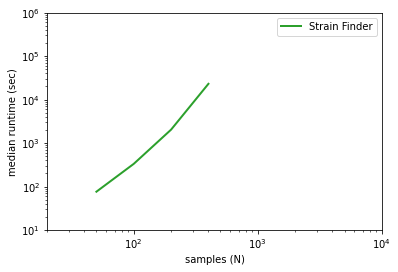

In [194]:
# Aggregate simulation results by finding the mean/min/std of each fit_seed
# and then taking the mean of each of these values over the sim_seed.
# I could then plot each runtime value as the mean

fit_type_list = ['sfinder']

palette = {
# 'sfinder', 'sfacts1_cpu', 'sfacts1_gpu', 'sfacts2', 'sfacts3'
    'sfacts44_cpu': 'tab:blue',
    'sfacts44_gpu': 'tab:purple',
#     'sfacts41_big': 'lightblue',
    'sfinder': 'tab:green',
}

d0 = (
    benchmarks1
    .groupby([
        'n',
        'fit_type',
#         'sim_seed',
        'fit_s_ratio',
    ])
    .runtime_s
    .agg(['median'])
    .reset_index()
)
# Drop the one sfinder run:
d0 = d0.drop(d0[lambda x: (x.n == 1_000) & (x.fit_s_ratio == 1) & (x.fit_type == 'sfinder')].index)

fig = plt.figure()

fit_label_map = {
    'sfacts44_gpu': 'StrainFacts (GPU)',
    'sfacts44_cpu': 'StrainFacts (CPU)',
    'sfinder': 'Strain Finder'

}

for fit_type in fit_type_list:
    d1 = d0[lambda x: x.fit_s_ratio==1].sort_values('n')[lambda x: x.fit_type == fit_type]
    if not fit_type in palette:
        continue
    plt.plot(d1['n'], d1['median'], c=palette[fit_type], linestyle='-', label=fit_label_map[fit_type], lw=2)
    
    
# for fit_type in fit_type_list:
#     d1 = d0[lambda x: x.fit_s_ratio==1.5].sort_values('n')[lambda x: x.fit_type == fit_type]
#     if not fit_type in palette:
#         continue
#     plt.plot(d1['n'], d1['median'], c=palette[fit_type], linestyle='--', label='__nolegend__', lw=2)
    
    
# plt.plot([], [], c='grey', linestyle='-', label='1x strains', lw=2)
# plt.plot([], [], c='grey', linestyle='--', label='1.5x strains', lw=2)

plt.yscale('log')
plt.xscale('log')
plt.xlim(2e1, 1e4)
plt.ylim(1e1, 1e6)

plt.legend()

plt.ylabel('median runtime (sec)')
plt.xlabel('samples (N)')

plt.savefig('fig/runtime_profiling_just_sfinder_1x.png', dpi=400)

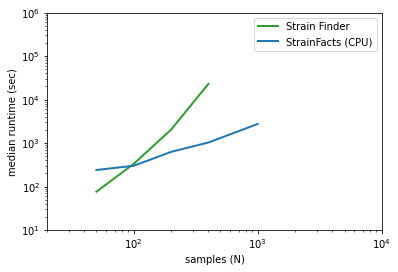

In [196]:
# Aggregate simulation results by finding the mean/min/std of each fit_seed
# and then taking the mean of each of these values over the sim_seed.
# I could then plot each runtime value as the mean

fit_type_list = ['sfinder', 'sfacts44_cpu', ]

palette = {
# 'sfinder', 'sfacts1_cpu', 'sfacts1_gpu', 'sfacts2', 'sfacts3'
    'sfacts44_cpu': 'tab:blue',
    'sfacts44_gpu': 'tab:purple',
#     'sfacts41_big': 'lightblue',
    'sfinder': 'tab:green',
}

d0 = (
    benchmarks1
    .groupby([
        'n',
        'fit_type',
#         'sim_seed',
        'fit_s_ratio',
    ])
    .runtime_s
    .agg(['median'])
    .reset_index()
)
# Drop the one sfinder run:
d0 = d0.drop(d0[lambda x: (x.n == 1_000) & (x.fit_s_ratio == 1) & (x.fit_type == 'sfinder')].index)

fig = plt.figure()

fit_label_map = {
    'sfacts44_gpu': 'StrainFacts (GPU)',
    'sfacts44_cpu': 'StrainFacts (CPU)',
    'sfinder': 'Strain Finder'

}

for fit_type in fit_type_list:
    d1 = d0[lambda x: x.fit_s_ratio==1].sort_values('n')[lambda x: x.fit_type == fit_type]
    if not fit_type in palette:
        continue
    plt.plot(d1['n'], d1['median'], c=palette[fit_type], linestyle='-', label=fit_label_map[fit_type], lw=2)
    
    
# for fit_type in fit_type_list:
#     d1 = d0[lambda x: x.fit_s_ratio==1.5].sort_values('n')[lambda x: x.fit_type == fit_type]
#     if not fit_type in palette:
#         continue
#     plt.plot(d1['n'], d1['median'], c=palette[fit_type], linestyle='--', label='__nolegend__', lw=2)
    
    
# plt.plot([], [], c='grey', linestyle='-', label='1x strains', lw=2)
# plt.plot([], [], c='grey', linestyle='--', label='1.5x strains', lw=2)

plt.yscale('log')
plt.xscale('log')
plt.xlim(2e1, 1e4)
plt.ylim(1e1, 1e6)

plt.legend()

plt.ylabel('median runtime (sec)')
plt.xlabel('samples (N)')

plt.savefig('fig/runtime_profiling_both_1x.png', dpi=400)

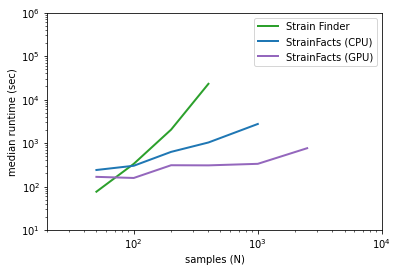

In [197]:
# Aggregate simulation results by finding the mean/min/std of each fit_seed
# and then taking the mean of each of these values over the sim_seed.
# I could then plot each runtime value as the mean

fit_type_list = ['sfinder', 'sfacts44_cpu', 'sfacts44_gpu']

palette = {
# 'sfinder', 'sfacts1_cpu', 'sfacts1_gpu', 'sfacts2', 'sfacts3'
    'sfacts44_cpu': 'tab:blue',
    'sfacts44_gpu': 'tab:purple',
#     'sfacts41_big': 'lightblue',
    'sfinder': 'tab:green',
}

d0 = (
    benchmarks1
    .groupby([
        'n',
        'fit_type',
#         'sim_seed',
        'fit_s_ratio',
    ])
    .runtime_s
    .agg(['median'])
    .reset_index()
)
# Drop the one sfinder run:
d0 = d0.drop(d0[lambda x: (x.n == 1_000) & (x.fit_s_ratio == 1) & (x.fit_type == 'sfinder')].index)

fig = plt.figure()

fit_label_map = {
    'sfacts44_gpu': 'StrainFacts (GPU)',
    'sfacts44_cpu': 'StrainFacts (CPU)',
    'sfinder': 'Strain Finder'

}

for fit_type in fit_type_list:
    d1 = d0[lambda x: x.fit_s_ratio==1].sort_values('n')[lambda x: x.fit_type == fit_type]
    if not fit_type in palette:
        continue
    plt.plot(d1['n'], d1['median'], c=palette[fit_type], linestyle='-', label=fit_label_map[fit_type], lw=2)
    
    
# for fit_type in fit_type_list:
#     d1 = d0[lambda x: x.fit_s_ratio==1.5].sort_values('n')[lambda x: x.fit_type == fit_type]
#     if not fit_type in palette:
#         continue
#     plt.plot(d1['n'], d1['median'], c=palette[fit_type], linestyle='--', label='__nolegend__', lw=2)
    
    
# plt.plot([], [], c='grey', linestyle='-', label='1x strains', lw=2)
# plt.plot([], [], c='grey', linestyle='--', label='1.5x strains', lw=2)

plt.yscale('log')
plt.xscale('log')
plt.xlim(2e1, 1e4)
plt.ylim(1e1, 1e6)

plt.legend()

plt.ylabel('median runtime (sec)')
plt.xlabel('samples (N)')

plt.savefig('fig/runtime_profiling_all_1x.png', dpi=400)

In [115]:
(
    benchmarks1
    .assign(runtime_min=lambda x: x.runtime_s / 60)
    .groupby([
        'n',
        'fit_type',
        'fit_s_ratio',
    ])
    .runtime_min
    .agg(['median', 'mean', 'max', 'min', 'std', 'count'])
    .reset_index()
    .set_index(['n', 'fit_s_ratio', 'fit_type']).sort_index()
)

median         mean          max  \
n    fit_s_ratio fit_type                                              
50   1.0         sfacts44_cpu     3.997350     4.242081    12.589893   
                 sfacts44_gpu     2.779650     3.491489     5.325230   
                 sfinder          1.266352     1.307778     2.487947   
     1.5         sfacts44_cpu     3.647813     3.933926     6.035208   
                 sfacts44_gpu     2.839560     3.447118     5.941290   
                 sfinder          4.566245     4.780923    10.665250   
100  1.0         sfacts44_cpu     4.999138     5.457830    13.788635   
                 sfacts44_gpu     2.620108     3.234780     5.436872   
                 sfinder          5.534815     6.454569    13.181945   
     1.5         sfacts44_cpu     5.799745     6.506139    15.066022   
                 sfacts44_gpu     3.552253     3.454393     5.375050   
                 sfinder         20.962317    20.108854    36.062393   
200  1.0         sfacts44_cpu    10.428555    10.450707    24.396320   
                 sfacts44_gpu     5.142477     4.326950     6.979855   
                 sfinder         33.875100    37.847136    60.168100   
     1.5         sfacts44_cpu     9.593337     9.838465    14.028265   
                 sfacts44_gpu     3.627823     3.873604     6.896437   
                 sfinder        157.843898   165.344126   283.838862   
400  1.0         sfacts44_cpu    17.155452    17.992375    36.342582   
                 sfacts44_gpu     5.106610     4.413809     7.329362   
                 sfinder        383.172952   395.323930   645.861507   
     1.5         sfacts44_cpu    17.189800    18.568173    40.502582   
                 sfacts44_gpu     5.287708     4.576642     6.612870   
                 sfinder       1846.496948  1822.071570  3102.255593   
1000 1.0         sfacts44_cpu    45.698230    46.694137    97.106352   
                 sfacts44_gpu     5.540113     5.423869     8.292558   
                 sfinder       1225.841000  1225.841000  1225.841000   
     1.5         sfacts44_cpu    53.084410    55.342185   134.182332   
                 sfacts44_gpu     6.867888     6.178904     9.676917   
2500 1.0         sfacts44_gpu    12.677358    11.834301    15.544275   
     1.5         sfacts44_gpu     8.870237     7.882858    11.017255   

                                       min         std  count  
n    fit_s_ratio fit_type                                      
50   1.0         sfacts44_cpu     2.590465    1.945211     25  
                 sfacts44_gpu     1.968182    1.315757     25  
                 sfinder          0.691975    0.423538     25  
     1.5         sfacts44_cpu     2.542473    0.772069     25  
                 sfacts44_gpu     1.864488    1.406088     25  
                 sfinder          1.671330    2.089010     25  
100  1.0         sfacts44_cpu     3.948092    1.978078     25  
                 sfacts44_gpu     1.890380    1.319825     25  
                 sfinder          4.242883    2.683734     25  
     1.5         sfacts44_cpu     4.035102    2.586619     25  
                 sfacts44_gpu     1.898063    1.375106     25  
                 sfinder          9.163455    7.000320     25  
200  1.0         sfacts44_cpu     5.266222    3.589591     25  
                 sfacts44_gpu     2.046695    1.474205     25  
                 sfinder         20.447113   11.179882     25  
     1.5         sfacts44_cpu     7.123477    1.623010     25  
                 sfacts44_gpu     2.030487    1.388226     25  
                 sfinder         80.384288   44.598440     25  
400  1.0         sfacts44_cpu    10.009287    5.567794     25  
                 sfacts44_gpu     2.101808    1.602139     25  
                 sfinder        230.886058   98.479530     25  
     1.5         sfacts44_cpu    12.860967    6.075718     25  
                 sfacts44_gpu     2.143130    1.271392     25  
                 sfinder       1179.902122  597.728147     

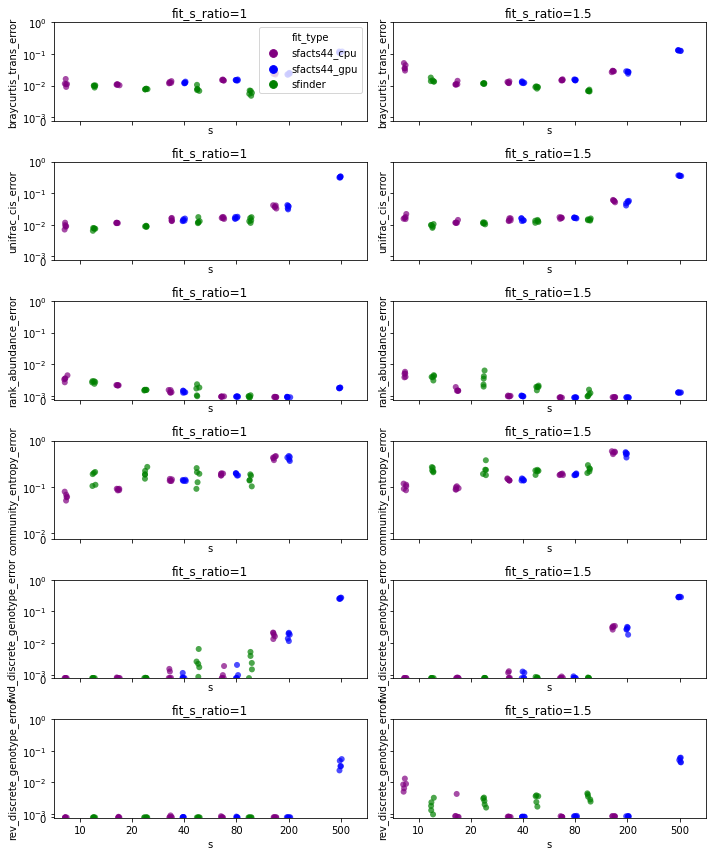

In [13]:
d0 = (
    benchmarks2
#     [lambda x: x.g == 250]
#     [lambda x: (
# #         (x.mu == 5)
# #         (x.fit_seed == 0)
#         (x.fit_type.isin([
#             'sfinder',
#             'sfacts1_cpu',
#             'sfacts1_gpu',
# #             'sfacts2',
# #             'sfacts3',
#         ]))
#     )]
    .groupby([
        's',
        'g',
        'fit_type',
        'sim_seed',
        'fit_s_ratio',
#         'fit_seed',
    ], as_index=False)
#     .apply(lambda d: d.loc[d.metagenotype_prediction_error.idxmin()])
    .min()
)
# d0['fit_type_fit_s'] = d0['fit_type'] + '-s' + d0['fit_s'].astype(str)

palette = {
# 'sfinder', 'sfacts1_cpu', 'sfacts1_gpu', 'sfacts2', 'sfacts3'
    'sfacts44_cpu': 'purple',
    'sfacts44_gpu': 'blue',
#     'sfacts41_big': 'lightblue',
    'sfinder': 'green',
#     'sfacts44_big': 'peachpuff',
#     'sfacts45_big': 'violet',
#     'sfacts46_big': 'lightgreen',

}

metric_list = [
#     ("metagenotype_prediction_error", dict(value='symlog', linthresh=1e-2, linscale=0.1), dict(bottom=-1e-3, top=1e0)),
    ("braycurtis_trans_error", dict(value='symlog', linthresh=1e-3, linscale=0.1), dict(bottom=-1e-4, top=1e0)),
#     ("unifrac_trans_error", dict(value='symlog', linthresh=1e-3, linscale=0.1), dict(bottom=-1e-4, top=1e0)),
    ("unifrac_cis_error", dict(value='symlog', linthresh=1e-3, linscale=0.1), dict(bottom=-1e-4, top=1e0)),
    ("rank_abundance_error", dict(value='symlog', linthresh=1e-3, linscale=0.1), dict(bottom=-1e-4, top=1e0)),
    ("community_entropy_error", dict(value='symlog', linthresh=1e-2, linscale=0.1), dict(bottom=-1e-3, top=1e0)),
#     ("fwd_genotype_error", dict(value='symlog', linthresh=1e-3, linscale=0.1), dict(bottom=-1e-4, top=1e0)),
#     ("rev_genotype_error", dict(value='symlog', linthresh=1e-3, linscale=0.1), dict(bottom=-1e-4, top=1e0)),
    ("fwd_discrete_genotype_error", dict(value='symlog', linthresh=1e-3, linscale=0.1), dict(bottom=-1e-4, top=1e0)),
    ("rev_discrete_genotype_error", dict(value='symlog', linthresh=1e-3, linscale=0.1), dict(bottom=-1e-4, top=1e0)),
#     ("runtime", dict(value='log'), dict(bottom=1e1, top=1e6)),
          ]


s_list = [10, 20, 40, 80, 200, 500]
fit_s_ratio_list = [1, 1.5]
g = 250
ncol = len(fit_s_ratio_list)
nrow = len(metric_list)
# nrow = int(np.ceil(len(metrics) / ncol))

fig, axs = plt.subplots(nrow, ncol, figsize=(5 * ncol, 2 * nrow), sharey='row', sharex=True)
axs = axs.reshape((nrow, ncol))

for (met, scale_kws, ylim_kws), row in zip(metric_list, axs):
    row[0].set_yscale(**scale_kws)
    row[0].set_ylim(**ylim_kws)
    row[0].set_ylabel(met)
    for fit_s_ratio, ax in zip(fit_s_ratio_list, row):
        d1 = d0[(d0.fit_s_ratio == fit_s_ratio) & (d0.g == g)]
        ax.set_title(f'fit_s_ratio={fit_s_ratio}')
        sns.stripplot(
            x='s',
            y=met,
            data=d1,
            hue='fit_type',
            hue_order=palette.keys(),
            order=s_list,
            s=6,
            palette=palette,
            ax=ax,
            jitter=True,
            alpha=0.7,
            dodge=True,
        )
    
    
for ax in axs.flatten()[1:]:
    leg = ax.get_legend()
    if leg:
        leg.remove()
        
# for ax in axs[:-1].flatten():
#     ax.set_ylim(bottom=1e-4, top=1e0)
    
fig.tight_layout()

/opt/conda/lib/python3.7/site-packages/pandas/core/generic.py:4153: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)


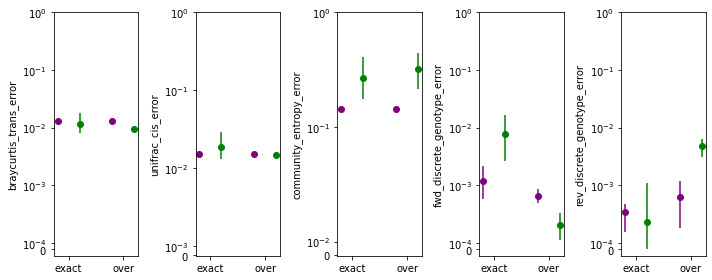

In [14]:
# Aggregate simulation results by finding the mean/min/std of each fit_seed
# and then taking the mean of each of these values over the sim_seed.
# I could then plot each runtime value as the mean


palette = {
# 'sfinder', 'sfacts1_cpu', 'sfacts1_gpu', 'sfacts2', 'sfacts3'
    'sfacts44_cpu': 'purple',
#     'sfacts41_gpu': 'blue',
#     'sfacts44_big': 'peachpuff',
    'sfinder': 'green',
}

d0 = (
    benchmarks2
#     [lambda x: x.g == 250]
#     [lambda x: (
# #         (x.mu == 5)
# #         (x.fit_seed == 0)
#         (x.fit_type.isin([
#             'sfinder',
#             'sfacts1_cpu',
#             'sfacts1_gpu',
# #             'sfacts2',
# #             'sfacts3',
#         ]))
#     )]
    .groupby([
        's',
        'g',
        'n',
        'fit_type',
        'fit_s_ratio',
        'sim_seed',
#         'fit_seed',
    ], as_index=False)
    .agg(['mean', 'min', 'max', 'std', 'count'])
    .reset_index()
    .groupby([
        's',
        'g',
        'n',
        'fit_type',
        'fit_s_ratio',
#         'sim_seed',
#         'fit_seed',
    ])
    .agg(['mean', 'count'])
)

g = 250
s = 40


fit_type_list = list(palette.keys())

d1 = d0.reset_index()[lambda x: (x.s==s) & (x.fit_type.isin(fit_type_list)) & (x.g == g)]
metric_list = [
#     ("metagenotype_prediction_error", dict(value='symlog', linthresh=1e-2, linscale=0.1), dict(bottom=-1e-3, top=1e0)),
    ("braycurtis_trans_error", dict(value='symlog', linthresh=1e-4, linscale=0.1), dict(bottom=-1e-4, top=1e0)),
#     ("unifrac_trans_error", dict(value='symlog', linthresh=1e-3, linscale=0.1), dict(bottom=-1e-4, top=1e0)),
    ("unifrac_cis_error", dict(value='symlog', linthresh=1e-3, linscale=0.1), dict(bottom=-1e-4, top=1e0)),
    ("community_entropy_error", dict(value='symlog', linthresh=1e-2, linscale=0.1), dict(bottom=-1e-3, top=1e0)),
#     ("rank_abundance_error", dict(value='symlog', linthresh=1e-3, linscale=0.1), dict(bottom=-1e-4, top=1e0)),
#     ("fwd_genotype_error", dict(value='symlog', linthresh=1e-3, linscale=0.1), dict(bottom=-1e-4, top=1e0)),
#     ("rev_genotype_error", dict(value='symlog', linthresh=1e-3, linscale=0.1), dict(bottom=-1e-4, top=1e0)),
    ("fwd_discrete_genotype_error", dict(value='symlog', linthresh=1e-4, linscale=0.1), dict(bottom=-1e-4, top=1e0)),
    ("rev_discrete_genotype_error", dict(value='symlog', linthresh=1e-4, linscale=0.1), dict(bottom=-1e-4, top=1e0)),
#     ("runtime", dict(value='log'), dict(bottom=1e1, top=1e6)),
          ]

fig, axs = plt.subplots(1, len(metric_list), figsize=(2 * len(metric_list), 4))

for (met, scale_kws, ylim_kws), ax in zip(metric_list, axs):
    ax.set_ylabel(met)
    ax.set_yscale(**scale_kws)
    ax.set_ylim(**ylim_kws)
    ax.set_xticks([1, 1.5])
    ax.set_xticklabels(['exact', 'over'])
#     ax.set_ylim(1e-5)
    for fit_s_ratio, d2 in d1.groupby(['fit_s_ratio']):
        for fit_type, offset in zip(fit_type_list, np.linspace(-0.1, 0.1, num=len(fit_type_list))):
            d3 = d2[lambda x: (x.fit_type == fit_type)]
#             print(fit_s_ratio, fit_type, d3.shape)
            if d3.empty:
                continue
#             ax.scatter([fit_s_ratio + offset], d3[(met, 'min', 'mean')], edgecolor=palette[fit_type], color='white')
            ax.scatter([fit_s_ratio + offset], d3[(met, 'mean', 'mean')], color=palette[fit_type])
#             ax.vlines([fit_s_ratio + offset], d3[(met, 'min', 'mean')], d3[(met, 'mean', 'mean')], color=palette[fit_type])
            ax.vlines([fit_s_ratio + offset], d3[(met, 'min', 'mean')], d3[(met, 'max', 'mean')], color=palette[fit_type])

    
    
fig.tight_layout()

unifrac_cis_error 1.0 (0.8, 0.14367208180696023) 1.04
unifrac_cis_error 1.5 (0.8, 0.14367208180696023) 1.54
community_entropy_error 1.0 (0.4, 0.6761033140231469) 1.04
community_entropy_error 1.5 (0.0, 0.012185780355344813) 1.54
fwd_discrete_genotype_error 1.0 (0.08, 0.0367138563627041) 1.04
fwd_discrete_genotype_error 1.5 (0.6, 0.6723358083659552) 1.54
rev_discrete_genotype_error 1.0 (0.9, 0.025369859822053656) 1.04
rev_discrete_genotype_error 1.5 (0.0, 0.012185780355344813) 1.54


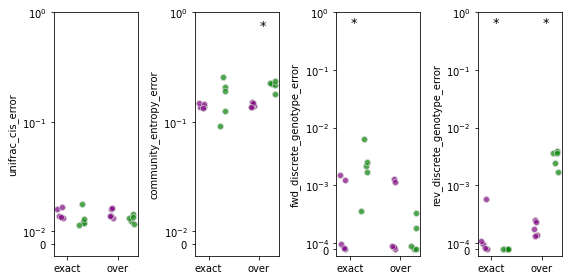

In [15]:
# Aggregate simulation results by finding the mean/min/std of each fit_seed
# and then taking the mean of each of these values over the sim_seed.
# I could then plot each runtime value as the mean


palette = {
# 'sfinder', 'sfacts1_cpu', 'sfacts1_gpu', 'sfacts2', 'sfacts3'
    'sfacts44_cpu': 'purple',
#     'sfacts41_gpu': 'blue',
#     'sfacts44_big': 'peachpuff',
    'sfinder': 'green',
}

d0 = (
    benchmarks2
#     [lambda x: x.g == 250]
#     [lambda x: (
# #         (x.mu == 5)
# #         (x.fit_seed == 0)
#         (x.fit_type.isin([
#             'sfinder',
#             'sfacts1_cpu',
#             'sfacts1_gpu',
# #             'sfacts2',
# #             'sfacts3',
#         ]))
#     )]
    .groupby([
        's',
        'g',
        'n',
        'fit_type',
        'fit_s_ratio',
        'sim_seed',
#         'fit_seed',
    ], as_index=False)
    .agg(['mean', 'min', 'max', 'std', 'count', 'median'])
    .reset_index()
#     .groupby([
#         's',
#         'g',
#         'n',
#         'fit_type',
#         'fit_s_ratio',
# #         'sim_seed',
# #         'fit_seed',
#     ])
#     .agg(['mean', 'count'])
)

d0['jitter'] = np.random.random(d0.shape[0])

g = 250
s = 40


fit_type_list = list(palette.keys())

d1 = d0.reset_index()[lambda x: (x.s==s) & (x.fit_type.isin(fit_type_list)) & (x.g == g)]
metric_list = [
#     ("metagenotype_prediction_error", dict(value='symlog', linthresh=1e-2, linscale=0.1), dict(bottom=-1e-3, top=1e0)),
#     ("braycurtis_trans_error", dict(value='symlog', linthresh=1e-3, linscale=0.1), dict(bottom=-1e-3, top=1e0)),
#     ("unifrac_trans_error", dict(value='symlog', linthresh=1e-3, linscale=0.1), dict(bottom=-1e-4, top=1e0)),
    ("unifrac_cis_error", dict(value='symlog', linthresh=1e-2, linscale=0.1), dict(bottom=-1e-2, top=1e0)),
    ("community_entropy_error", dict(value='symlog', linthresh=1e-2, linscale=0.1), dict(bottom=-1e-2, top=1e0)),
#     ("rank_abundance_error", dict(value='symlog', linthresh=1e-3, linscale=0.1), dict(bottom=-1e-4, top=1e0)),
#     ("fwd_genotype_error", dict(value='symlog', linthresh=1e-3, linscale=0.1), dict(bottom=-1e-4, top=1e0)),
#     ("rev_genotype_error", dict(value='symlog', linthresh=1e-3, linscale=0.1), dict(bottom=-1e-4, top=1e0)),
    ("fwd_discrete_genotype_error", dict(value='symlog', linthresh=1e-4, linscale=0.1), dict(bottom=-1e-4, top=1e0)),
    ("rev_discrete_genotype_error", dict(value='symlog', linthresh=1e-4, linscale=0.1), dict(bottom=-1e-4, top=1e0)),
#     ("runtime", dict(value='log'), dict(bottom=1e1, top=1e6)),
          ]

fig, axs = plt.subplots(1, len(metric_list), figsize=(2 * len(metric_list), 4), sharex=True)

for (met, scale_kws, ylim_kws), ax in zip(metric_list, axs):
    ax.set_ylabel(met)
    ax.set_yscale(**scale_kws)
    ax.set_ylim(**ylim_kws)
#     ax.set_yscale('symlog', linthresh=1e-5)
    ax.set_xticks([1, 1.5])
    ax.set_xticklabels(['exact', 'over'])
#     ax.set_ylim(1e-5)
    for fit_s_ratio, d2 in d1.groupby(['fit_s_ratio']):
        mwu = lib.stats.mannwhitneyu('fit_type', (met, 'min'), data=d2.sort_values('sim_seed'))
        print(met, fit_s_ratio, mwu, d2['fit_s_ratio'].values[0] + 0.04)
        ax.annotate(
            pvalue_to_significance_marker(mwu[1]),
            xy=(
                d2['fit_s_ratio'].values[0] + 0.04,
                0.87
            ), ha='center', va='top', fontsize=13)
        for fit_type, offset in zip(fit_type_list, np.linspace(-1, 1, num=len(fit_type_list))):
            d3 = d2[lambda x: (x.fit_type == fit_type)]
#             print(fit_s_ratio, fit_type, d3.shape)
            if d3.empty:
                continue
            ax.scatter(d3['fit_s_ratio'] + d3['jitter'] * 0.07 + offset * 0.1, d3[(met, 'min')], edgecolor='lightgrey', color=palette[fit_type], alpha=0.7)
#             ax.vlines(d3['fit_s_ratio'] + d3['jitter'] * 0.07 + offset * 0.1, d3[(met, 'min')], d3[(met, 'median')], color=palette[fit_type], lw=1, alpha=0.7)

    
fig.tight_layout()

unifrac_cis_error 1.0 (0.8, 0.14367208180696023) 1.04
unifrac_cis_error 1.5 (0.8, 0.14367208180696023) 1.54
community_entropy_error 1.0 (0.4, 0.6761033140231469) 1.04
community_entropy_error 1.5 (0.0, 0.012185780355344813) 1.54
fwd_discrete_genotype_error 1.0 (0.08, 0.0367138563627041) 1.04
fwd_discrete_genotype_error 1.5 (0.6, 0.6723358083659552) 1.54
rev_discrete_genotype_error 1.0 (0.9, 0.025369859822053656) 1.04
rev_discrete_genotype_error 1.5 (0.0, 0.012185780355344813) 1.54


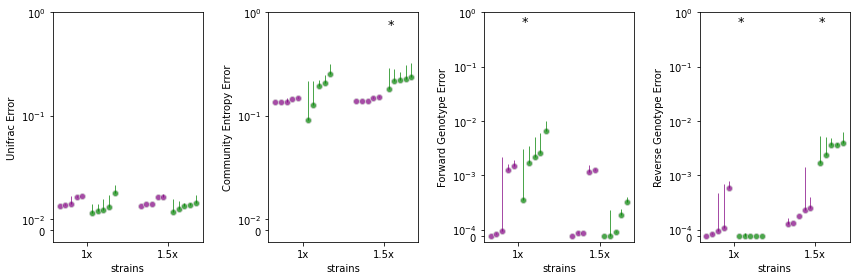

In [16]:
# Aggregate simulation results by finding the mean/min/std of each fit_seed
# and then taking the mean of each of these values over the sim_seed.
# I could then plot each runtime value as the mean


palette = {
# 'sfinder', 'sfacts1_cpu', 'sfacts1_gpu', 'sfacts2', 'sfacts3'
    'sfacts44_cpu': 'purple',
#     'sfacts41_gpu': 'blue',
#     'sfacts44_big': 'peachpuff',
    'sfinder': 'green',
}

d0 = (
    benchmarks2
#     [lambda x: x.g == 250]
#     [lambda x: (
# #         (x.mu == 5)
# #         (x.fit_seed == 0)
#         (x.fit_type.isin([
#             'sfinder',
#             'sfacts1_cpu',
#             'sfacts1_gpu',
# #             'sfacts2',
# #             'sfacts3',
#         ]))
#     )]
    .groupby([
        's',
        'g',
        'n',
        'fit_type',
        'fit_s_ratio',
        'sim_seed',
#         'fit_seed',
    ], as_index=False)
    .agg(['mean', 'min', 'max', 'std', 'count', 'median'])
    .reset_index()
#     .groupby([
#         's',
#         'g',
#         'n',
#         'fit_type',
#         'fit_s_ratio',
# #         'sim_seed',
# #         'fit_seed',
#     ])
#     .agg(['mean', 'count'])
)

# d0['jitter'] = np.random.random(d0.shape[0])

g = 250
s = 40


fit_type_list = list(palette.keys())

d1 = d0.reset_index()[lambda x: (x.s==s) & (x.fit_type.isin(fit_type_list)) & (x.g == g)]
metric_list = [
#     ("metagenotype_prediction_error", dict(value='symlog', linthresh=1e-2, linscale=0.1), dict(bottom=-1e-3, top=1e0)),
#     ("braycurtis_trans_error", dict(value='symlog', linthresh=1e-3, linscale=0.1), dict(bottom=-1e-3, top=1e0)),
#     ("unifrac_trans_error", dict(value='symlog', linthresh=1e-3, linscale=0.1), dict(bottom=-1e-4, top=1e0)),
    ("unifrac_cis_error", 'Unifrac Error', dict(value='symlog', linthresh=1e-2, linscale=0.1), dict(bottom=-1e-2, top=1e0)),
    ("community_entropy_error", 'Community Entropy Error', dict(value='symlog', linthresh=1e-2, linscale=0.1), dict(bottom=-1e-2, top=1e0)),
#     ("rank_abundance_error", dict(value='symlog', linthresh=1e-3, linscale=0.1), dict(bottom=-1e-4, top=1e0)),
#     ("fwd_genotype_error", dict(value='symlog', linthresh=1e-3, linscale=0.1), dict(bottom=-1e-4, top=1e0)),
#     ("rev_genotype_error", dict(value='symlog', linthresh=1e-3, linscale=0.1), dict(bottom=-1e-4, top=1e0)),
    ("fwd_discrete_genotype_error", 'Forward Genotype Error', dict(value='symlog', linthresh=1e-4, linscale=0.1), dict(bottom=-1e-4, top=1e0)),
    ("rev_discrete_genotype_error", 'Reverse Genotype Error', dict(value='symlog', linthresh=1e-4, linscale=0.1), dict(bottom=-1e-4, top=1e0)),
#     ("runtime", dict(value='log'), dict(bottom=1e1, top=1e6)),
          ]


fig, axs = plt.subplots(1, len(metric_list), figsize=(3 * len(metric_list), 4), sharex=True)

for (met, axis_label, scale_kws, ylim_kws), ax in zip(metric_list, axs):
    ax.set_ylabel(axis_label)
    ax.set_yscale(**scale_kws)
    ax.set_ylim(**ylim_kws)
#     ax.set_yscale('symlog', linthresh=1e-5)
    ax.set_xticks([1, 1.5])
    ax.set_xticklabels(['1x', '1.5x'])
    ax.set_xlabel('strains')
#     ax.set_ylim(1e-5)
    for fit_s_ratio, d2 in d1.groupby(['fit_s_ratio']):
        mwu = lib.stats.mannwhitneyu('fit_type', (met, 'min'), data=d2.sort_values('sim_seed'))
        print(met, fit_s_ratio, mwu, d2['fit_s_ratio'].values[0] + 0.04)
        ax.annotate(
            pvalue_to_significance_marker(mwu[1]),
            xy=(
                d2['fit_s_ratio'].values[0] + 0.04,
                0.87
            ), ha='center', va='top', fontsize=13)
        for fit_type, offset in zip(fit_type_list, np.linspace(-1, 1, num=len(fit_type_list))):
            d3 = d2[lambda x: (x.fit_type == fit_type)].sort_values((met, 'min'))
            d3['jitter'] = np.linspace(-1, 1, num=d3.shape[0])
#             print(fit_s_ratio, fit_type, d3.shape)
            if d3.empty:
                continue
            ax.scatter(d3['fit_s_ratio'] + d3['jitter'] * 0.07 + offset * 0.1, d3[(met, 'min')], edgecolor='lightgrey', color=palette[fit_type], alpha=0.7)
            ax.vlines(d3['fit_s_ratio'] + d3['jitter'] * 0.07 + offset * 0.1, d3[(met, 'min')], d3[(met, 'median')], color=palette[fit_type], lw=1, alpha=0.7)

    
fig.tight_layout(w_pad=2.)

unifrac_cis_error 1.0 WilcoxonResult(statistic=115.0, pvalue=0.20993918180465698)
0.0162664233352323
0.016597459185844
unifrac_cis_error 1.5 WilcoxonResult(statistic=135.0, pvalue=0.4741646647453308)
0.0151948087990349
0.014975339269735
braycurtis_trans_error 1.0 WilcoxonResult(statistic=103.0, pvalue=0.1134914755821228)
0.0132989166941319
0.0102510059561116
braycurtis_trans_error 1.5 WilcoxonResult(statistic=0.0, pvalue=5.960464477539063e-08)
0.0126129165642038
0.009568991030012
community_entropy_error 1.0 WilcoxonResult(statistic=7.0, pvalue=1.1324882507324219e-06)
0.14569445
0.2548229153368574
community_entropy_error 1.5 WilcoxonResult(statistic=0.0, pvalue=5.960464477539063e-08)
0.14105776
0.2961081552320405
fwd_discrete_genotype_error 1.0 WilcoxonResult(statistic=10.0, pvalue=2.562999725341797e-06)
0.001511973521127
0.0059986595191137
fwd_discrete_genotype_error 1.5 WilcoxonResult(statistic=33.0, pvalue=0.007184128373726576)
0.0002884463113553
0.0002134253463745
rev_discrete_genot

/opt/conda/lib/python3.7/site-packages/scipy/stats/morestats.py:2967: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/opt/conda/lib/python3.7/site-packages/scipy/stats/morestats.py:2967: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "


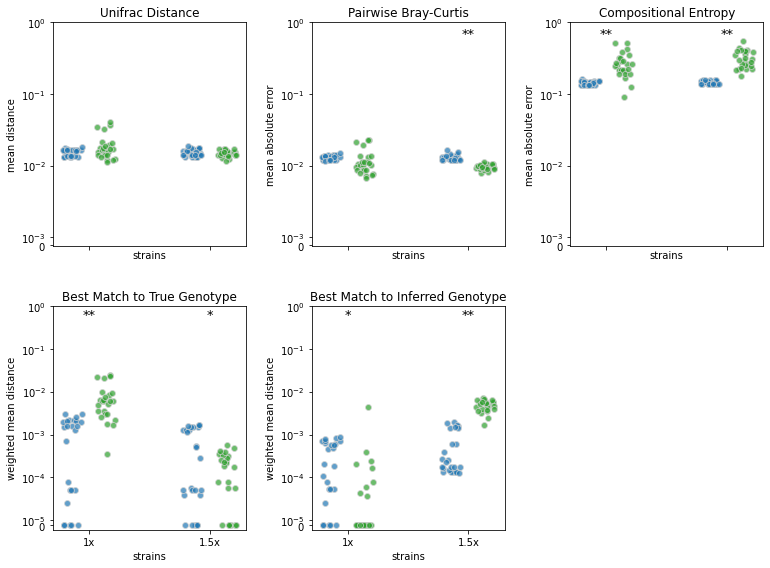

In [167]:
# Aggregate simulation results by finding the mean/min/std of each fit_seed
# and then taking the mean of each of these values over the sim_seed.
# I could then plot each runtime value as the mean


palette = {
# 'sfinder', 'sfacts1_cpu', 'sfacts1_gpu', 'sfacts2', 'sfacts3'
    'sfacts44_cpu': 'tab:blue',
#     'sfacts41_gpu': 'blue',
#     'sfacts44_big': 'peachpuff',
    'sfinder': 'tab:green',
}

d0 = (
    benchmarks2
#     [lambda x: x.g == 250]
#     [lambda x: (
# #         (x.mu == 5)
# #         (x.fit_seed == 0)
#         (x.fit_type.isin([
#             'sfinder',
#             'sfacts1_cpu',
#             'sfacts1_gpu',
# #             'sfacts2',
# #             'sfacts3',
#         ]))
#     )]
#     .groupby([
#         's',
#         'g',
#         'n',
#         'fit_type',
#         'fit_s_ratio',
# #         'sim_seed',
# #         'fit_seed',
#     ], as_index=False)
#     .agg(['mean', 'min', 'max', 'std', 'count', 'median'])
#     .reset_index()
#     .groupby([
#         's',
#         'g',
#         'n',
#         'fit_type',
#         'fit_s_ratio',
# #         'sim_seed',
# #         'fit_seed',
#     ])
#     .agg(['mean', 'count'])
)

d0['jitter'] = np.random.random(d0.shape[0]) * 2 - 1

g = 250
s = 40


fit_type_list = list(palette.keys())

d1 = d0.reset_index()[lambda x: (x.s==s) & (x.fit_type.isin(fit_type_list)) & (x.g == g)]
metric_list = [
#     ("metagenotype_prediction_error", dict(value='symlog', linthresh=1e-2, linscale=0.1), dict(bottom=-1e-3, top=1e0)),
#     ("unifrac_trans_error", dict(value='symlog', linthresh=1e-3, linscale=0.1), dict(bottom=-1e-4, top=1e0)),
    ("unifrac_cis_error", 'Unifrac Distance', 'mean distance', dict(value='symlog', linthresh=1e-3, linscale=0.1), dict(bottom=-1e-4, top=1e0)),
    ("braycurtis_trans_error", "Pairwise Bray-Curtis", 'mean absolute error', dict(value='symlog', linthresh=1e-3, linscale=0.1), dict(bottom=-1e-4, top=1e0)),
    ("community_entropy_error", 'Compositional Entropy', 'mean absolute error', dict(value='symlog', linthresh=1e-3, linscale=0.1), dict(bottom=-1e-4, top=1e0)),
#     ("rank_abundance_error", dict(value='symlog', linthresh=1e-3, linscale=0.1), dict(bottom=-1e-4, top=1e0)),
#     ("fwd_genotype_error", dict(value='symlog', linthresh=1e-3, linscale=0.1), dict(bottom=-1e-4, top=1e0)),
#     ("rev_genotype_error", dict(value='symlog', linthresh=1e-3, linscale=0.1), dict(bottom=-1e-4, top=1e0)),
    ("fwd_discrete_genotype_error", 'Best Match to True Genotype', 'weighted mean distance', dict(value='symlog', linthresh=1e-5, linscale=0.1), dict(bottom=-1e-5, top=1e0)),
    ("rev_discrete_genotype_error", 'Best Match to Inferred Genotype', 'weighted mean distance', dict(value='symlog', linthresh=1e-5, linscale=0.1), dict(bottom=-1e-5, top=1e0)),
#     ("runtime", dict(value='log'), dict(bottom=1e1, top=1e6)),
          ]

ncol = 3
nrow = int(np.ceil(len(metric_list) / ncol))

fig, axs = plt.subplots(nrow, ncol, figsize=(3.6 * ncol, 4 * nrow), sharex=True)

for (met, title, axis_label, scale_kws, ylim_kws), ax in zip(metric_list, axs.flatten()):
    ax.set_title(title)
    ax.set_ylabel(axis_label)
    ax.set_yscale(**scale_kws)
    ax.set_ylim(**ylim_kws)
#     ax.set_yscale('symlog', linthresh=1e-5)
    ax.set_xticks([1, 1.5])
    ax.set_xlim(0.85, 1.65)
    ax.set_xticklabels(['1x', '1.5x'])
    ax.set_xlabel('strains')
#     ax.set_ylim(1e-5)
    for fit_s_ratio, d2 in d1.groupby(['fit_s_ratio']):
        mwu = lib.stats.wilcoxon('fit_type', met, data=d2.sort_values(['sim_seed', 'fit_seed']))
        print(met, fit_s_ratio, mwu, )
        ax.annotate(
            pvalue_to_significance_marker(mwu[1]),
            xy=(
                d2['fit_s_ratio'].values[0],
                0.87
            ), ha='center', va='top', fontsize=13)
        for fit_type, offset in zip(fit_type_list, np.linspace(-1, 1, num=len(fit_type_list))):
            d3 = d2[lambda x: (x.fit_type == fit_type)]#.sort_values((met, 'min'))
            print(d3[met].median())
#             print(fit_s_ratio, fit_type, d3.shape)
            if d3.empty:
                continue
            ax.scatter(d3['fit_s_ratio'] + d3['jitter'] * 0.04 + offset * 0.07, d3[met], edgecolor='lightgrey', color=palette[fit_type], alpha=0.7)

axs[-1, -1].axis('off')

    
fig.tight_layout(w_pad=2., h_pad=3.)
fig.savefig('fig/accuracy_benchmarking.png', dpi=400)

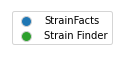

In [170]:
fig, ax = plt.subplots(figsize=(2.0, 1.0))
for fit_type, fit_name in [('sfacts44_cpu', 'StrainFacts'), ('sfinder', 'Strain Finder')]:
    ax.scatter([], [], edgecolor='lightgrey', color=palette[fit_type], label=fit_name, s=100)
ax.legend(loc='upper left')
ax.axis('off')
fig.savefig('fig/accuracy_benchmarking_legend.png', dpi=400)

In [104]:
_benchmarks = []
for n, g, s, sim_seed, fit_seed in tqdm(list(product(
    [100, 200, 500, 1000, 2500, 10000],
    [250, 500, 1000],
    [20, 40, 100, 200, 400],
    range(5),
    range(5),
))):
    sim_prefix = f"data/sfacts_simulate-model_simplest_simulation-n{n}-g{g}-s{s}-pi40-mu100-eps10-seed{sim_seed}"
    mgen_prefix = f"{sim_prefix}.metagenotype-n{n}-g{g}"
    eval_path = f"{mgen_prefix}.fit-sfacts44_gpumem-s{s}-seed{fit_seed}.gpumem"
#     print(eval_path)
    try:
        with open(eval_path) as f:
            max_vmem = max([int(line) for i, line in enumerate(f)])
    except FileNotFoundError:
#         print(f"Not found: {eval_path}")
        pass
    else:
        meta_dict = dict(
            path=eval_path, n=n, s=s, g=g, sim_seed=sim_seed, fit_seed=fit_seed, max_vmem=max_vmem,
        )
        _benchmarks.append(meta_dict)
_benchmarks = pd.DataFrame(_benchmarks).set_index('path')
print(_benchmarks.shape)
benchmarks3 = _benchmarks

100%|██████████| 2250/2250 [00:02<00:00, 839.48it/s]

(321, 6)


Text(0.5, 0, 'samples')

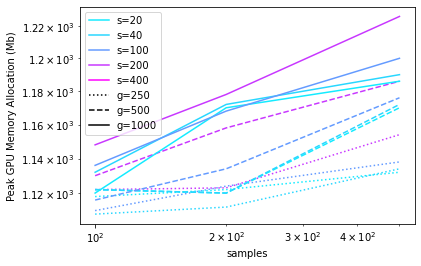

In [21]:
d0 = benchmarks3.groupby(['n', 'g', 's']).max_vmem.median().reset_index().assign(n_to_s_ratio=lambda x: x.n / x.s)
ordered_s_list = [20, 40, 100, 200, 400]
palette = {s: v for s, v in zip(ordered_s_list, mpl.cm.cool(ordered_s_list))}
ls_map = {250: ':', 500: '--', 1000: '-'}

for (g, s), d1 in d0.groupby(['g', 's']):
    plt.plot('n', 'max_vmem', ls=ls_map[g], c=palette[s], data=d1.sort_values('n'), label='__nolegend__')
    
for s in ordered_s_list:
    plt.plot([], [], ls='-', c=palette[s], label=f's={s}')
for g in d0.g.unique():
    plt.plot([], [], ls=ls_map[g], c='black', label=f'g={g}')
plt.legend(loc='upper left')

plt.yscale('log')
plt.xscale('log')
plt.ylabel('Peak GPU Memory Allocation (Mb)')
plt.xlabel('samples')
# plt.ylim(4e2, 5e3)

In [22]:
# data/sfacts_simulate-model_simplest_simulation-n100-g500-s400-pi40-mu100-eps10-seed0.metagenotype-n100-g500.fit-sfacts44_timeit-s400-g1000000-seed2.world.nc


import re

_benchmarks = []
for n, g, s, fit_seed, sim_seed, fit_type in tqdm(list(product(
    [100, 200, 500, 1000, 2500, 10000],
    [250, 500, 1000],
    [20, 40, 100, 200, 400],
    range(3),
    range(3),
    ['sfacts44', 'sfinder']
))):
    sim_prefix = f"data/sfacts_simulate-model_simplest_simulation-n{n}-g{g}-s{s}-pi40-mu100-eps10-seed{sim_seed}"
    mgen_prefix = f"{sim_prefix}.metagenotype-n{n}-g{g}"
    eval_path = f"{mgen_prefix}.fit-{fit_type}_timeit-s{s}-seed{fit_seed}.time"
#     print(eval_path)
    try:
        with open(eval_path) as f:
            d = f.readlines()
    except FileNotFoundError:
#         print(eval_path)
        continue
    else:
        if len(d) == 0:
#             print(eval_path)
            continue
        maxrss = int(re.match('.* ([0-9]+)maxresident\)k', d[0])[1])
    meta_dict = dict(
        path=eval_path,
        n=n,
        g=g,
        s=s,
        fit_seed=fit_seed,
        sim_seed=sim_seed,
        fit_type=fit_type,
        maxrss=maxrss,
    )
    _benchmarks.append(meta_dict)
_benchmarks = pd.DataFrame(_benchmarks).set_index('path')
print(_benchmarks.shape)
benchmarks4 = _benchmarks

100%|██████████| 1620/1620 [00:12<00:00, 131.70it/s]

(1134, 7)


In [23]:
benchmarks4[lambda x: x.fit_type=='sfacts44'].groupby(['n', 'g', 's']).maxrss.median()

n      g     s  
100    250   20      384740
             40      386152
             100     389556
             200     396636
             400     411696
                     ...   
10000  1000  20     2454276
             40     2454268
             100    2544232
             200    2879264
             400    3692688
Name: maxrss, Length: 90, dtype: int64

In [24]:
benchmarks4.groupby(['n', 'g', 's', 'fit_type']).apply(len).xs('sfacts44', level='fit_type')

n      g     s  
100    250   20     9
             40     9
             100    9
             200    9
             400    9
                   ..
10000  1000  20     9
             40     9
             100    9
             200    9
             400    9
Length: 90, dtype: int64

In [75]:
import statsmodels.formula.api as smf

d0 = (
    benchmarks4
    .drop(benchmarks4[lambda x: (x.n == 10000) & (x.g==1000)].index)  # These must have gotten swapped.
    .groupby(['n', 'g', 's', 'fit_type', 'sim_seed', 'fit_seed'])
    .maxrss
    .max()
    .reset_index()
    .assign(
        n_to_s_ratio=lambda x: x.n / x.s,
        maxrss_mb=lambda x: x.maxrss / 1e3
    )
)

fit = smf.ols('maxrss ~ n:g + n:s + g:s', data=d0[lambda x: (x.fit_type=='sfacts44')]).fit()
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 maxrss   R-squared:                       0.997
Model:                            OLS   Adj. R-squared:                  0.997
Method:                 Least Squares   F-statistic:                 9.187e+04
Date:                Fri, 07 Jan 2022   Prob (F-statistic):               0.00
Time:                        09:51:06   Log-Likelihood:                -9825.4
No. Observations:                 765   AIC:                         1.966e+04
Df Residuals:                     761   BIC:                         1.968e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   2.784e+05   4921.452     56.563      0.000    2.69e+05    2.88e+05
n:g            1.3234      0.003    405.005      0.000       1.317       1.330
n:s            0.1100      0.006     17.694      0.000       0.098       0.122
g:s            0.2787      0.034      8.180      0.000       0.212       0.346
==============================================================================
Omnibus:                      336.423   Durbin-Watson:                   0.428
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1485.921
Skew:                          -2.042   Prob(JB):                         0.00
Kurtosis:                       8.471   Cond. No.                     2.44e+06
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.44e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [41]:
d0_extrapolate = pd.DataFrame(dict(g=1000, s=400, n=np.logspace(np.log10(100), np.log10(50_000))))
d0_extrapolate['predict_mb'] = fit.predict(d0_extrapolate) / 1_000

d0_extrapolate[d0_extrapolate.predict_mb < 32_000].iloc[-1]

g              1000.000000
s               400.000000
n             20577.985689
predict_mb    28527.464145
Name: 42, dtype: float64

Text(0.5, 0, 'samples')

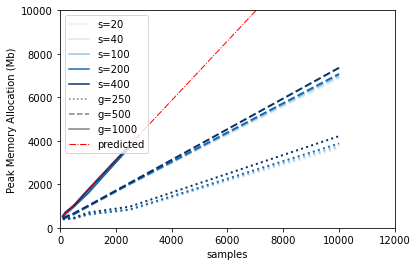

In [71]:
d0 = (
    benchmarks4
    .drop(benchmarks4[lambda x: (x.n == 10000) & (x.g==1000)].index)  # These must have gotten swapped.
    .groupby(['n', 'g', 's', 'fit_type'])
    .maxrss
    .median()
    .reset_index()
    .assign(
        n_to_s_ratio=lambda x: x.n / x.s,
        maxrss_mb=lambda x: x.maxrss / 1e3
    )
)
ordered_s_list = [20, 40, 100, 200, 400]

ls_map = {250: ':', 500: '--', 1000: '-'}

fig, ax = plt.subplots()
for fit_type, cm in zip(['sfacts44'], [mpl.cm.Blues]):
    palette = {s: v for s, v in zip(ordered_s_list, cm(ordered_s_list))}
    for (s, g), d1 in d0[d0.fit_type == fit_type].sort_values('n').groupby(['s', 'g']):
        ax.plot('n', 'maxrss_mb', ls=ls_map[g], c=palette[s], data=d1, lw=2, label='__nolegend__')
    for s in d0.s.sort_values().unique():
        ax.plot([], [], ls='-', c=palette[s], label=f's={s}')


for g in [250, 500, 1000]:
    plt.plot([], [], ls=ls_map[g], color='grey', label=f'g={g}')

plt.plot('n', 'predict_mb', data=d0_extrapolate, lw=1, color='red', ls='dashdot', label='predicted')


ax.legend(loc='upper left', ncol=1)

# ax.set_yscale('log')
# ax.set_xscale('log')
ax.set_xlim(0, 1.2e4)
ax.set_ylim(0, 1.0e4)
ax.set_ylabel('Peak Memory Allocation (Mb)')
ax.set_xlabel('samples')
# ax.set_ylim(5e1, 1e4)
# fig.tight_layout()

In [97]:
extrapolate2 = pd.DataFrame(dict(g=1000, s=100, n=np.logspace(np.log10(100), np.log10(50_000))))
extrapolate2['predict_mb'] = fit.predict(extrapolate2) / 1_000

extrapolate2[extrapolate2.predict_mb < 32_000].iloc[-1]

g              1000.000000
s               100.000000
n             23360.593988
predict_mb    31478.056733
Name: 43, dtype: float64

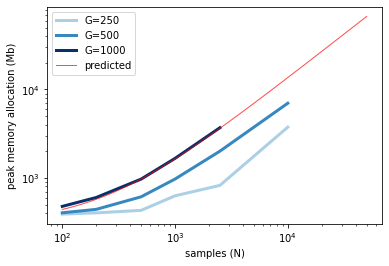

In [143]:
d0 = (
    benchmarks4
    [lambda x: x.s == 100]
    [lambda x: ~((x.n == 10000) & (x.g==1000))]  # These must have gotten RAM swapped.
    .groupby(['n', 'g', 's', 'fit_type'])
    .maxrss
    .median()
    .reset_index()
    .assign(
        n_to_s_ratio=lambda x: x.n / x.s,
        maxrss_mb=lambda x: x.maxrss / 1e3
    )
)
ordered_g_list = [250, 500, 1000]

ls_map = {250: ':', 500: '--', 1000: '-'}

fig, ax = plt.subplots()
for fit_type, cm in zip(['sfacts44'], [mpl.cm.Blues]):
    palette = {s: v for s, v in zip([None] + ordered_g_list, cm(np.linspace(0, 1, num=len(ordered_g_list) + 1)))}
    for g, d1 in d0[d0.fit_type == fit_type].sort_values(['n', 'g']).groupby(['g']):
        ax.plot('n', 'maxrss_mb', ls='-', c=palette[g], data=d1, lw=3, label=f'G={g}')
#     for s in d0.s.sort_values().unique():
#         ax.plot([], [], ls='-', c=palette[g], label=f'g={g}')


# for g in [250, 500, 1000]:
#     plt.plot([], [], ls=ls_map[g], color='grey', label=f'g={g}')

plt.plot('n', 'predict_mb', data=extrapolate2, lw=1, color='red', ls='-', label='predicted', alpha=0.7)


ax.legend(loc='upper left', ncol=1)

ax.set_yscale('log')
ax.set_xscale('log')
ax.set_ylabel('peak memory allocation (Mb)')
ax.set_xlabel('samples (N)')
# ax.set_ylim(5e1, 1e4)
# fig.tight_layout()

fig.savefig('fig/memory_profiling.png', dpi=400)

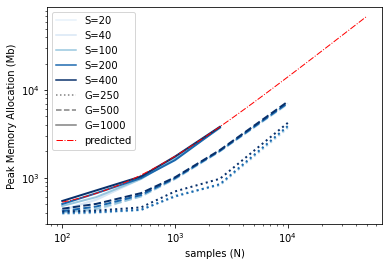

In [172]:
d0 = (
    benchmarks4
    .drop(benchmarks4[lambda x: (x.n == 10000) & (x.g==1000)].index)  # These must have gotten swapped.
    .groupby(['n', 'g', 's', 'fit_type'])
    .maxrss
    .median()
    .reset_index()
    .assign(
        n_to_s_ratio=lambda x: x.n / x.s,
        maxrss_mb=lambda x: x.maxrss / 1e3
    )
)
ordered_s_list = [20, 40, 100, 200, 400]

ls_map = {250: ':', 500: '--', 1000: '-'}

fig, ax = plt.subplots()
for fit_type, cm in zip(['sfacts44'], [mpl.cm.Blues]):
    palette = {s: v for s, v in zip(ordered_s_list, cm(ordered_s_list))}
    for (s, g), d1 in d0[d0.fit_type == fit_type].sort_values('n').groupby(['s', 'g']):
        ax.plot('n', 'maxrss_mb', ls=ls_map[g], c=palette[s], data=d1, lw=2, label='__nolegend__')
    for s in d0.s.sort_values().unique():
        ax.plot([], [], ls='-', c=palette[s], label=f'S={s}')


for g in [250, 500, 1000]:
    plt.plot([], [], ls=ls_map[g], color='grey', label=f'G={g}')

plt.plot('n', 'predict_mb', data=d0_extrapolate, lw=1, color='red', ls='dashdot', label='predicted')


ax.legend(loc='upper left', ncol=1)

ax.set_yscale('log')
ax.set_xscale('log')
ax.set_ylabel('Peak Memory Allocation (Mb)')
ax.set_xlabel('samples (N)')
# ax.set_ylim(5e1, 1e4)
# fig.tight_layout()

fig.savefig('doc/static/memory_profiling_more_strains_figure.pdf', dpi=400)